<a href="https://colab.research.google.com/github/OIBSIP-25-26/project2/blob/main/Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

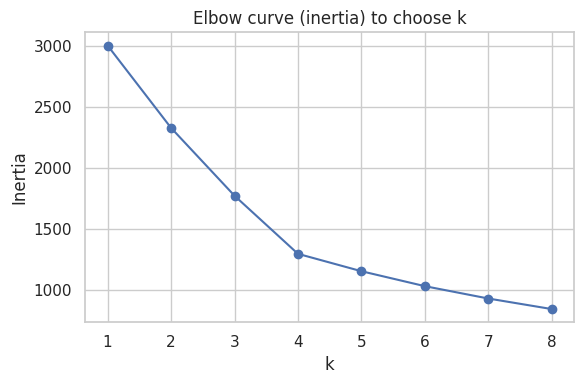

Cluster centers (approx):
      recency  frequency    monetary  cluster
0   36.085616   7.390411  299.184932        0
1   33.930283   3.470588  289.082004        1
2   41.318182   5.234848  937.109015        2
3  150.111111   4.555556  336.479487        3


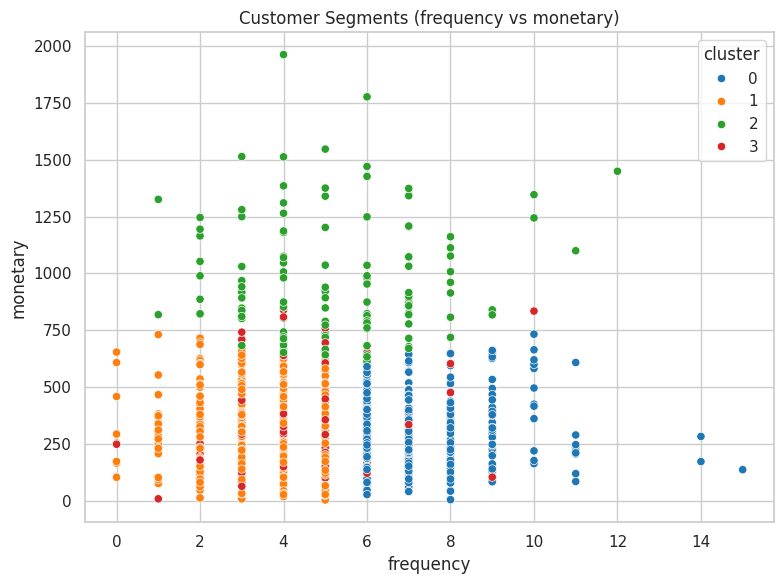

Segmentation completed. Outputs in: customer_segmentation_output


In [ ]:
"""
customer_segmentation.py
Performs KMeans segmentation on synthetic e-commerce customers.
Run: python customer_segmentation.py
Generates: synthetic CSV, cluster assignments plot, cluster centers printed.
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
import os
sns.set(style="whitegrid")
OUT_DIR = "customer_segmentation_output"
os.makedirs(OUT_DIR, exist_ok=True)
np.random.seed(1)

# --- Synthetic dataset ---
n_customers = 1000
customer_id = [f"C{1000+i}" for i in range(n_customers)]
recency = np.random.exponential(scale=50, size=n_customers).astype(int)        # days since last purchase
frequency = np.random.poisson(lam=5, size=n_customers)                       # purchases in period
monetary = np.round(np.random.gamma(shape=2, scale=200, size=n_customers),2)  # total spend
age = np.random.normal(loc=35, scale=10, size=n_customers).astype(int)
gender = np.random.choice(["M","F"], size=n_customers, p=[0.48,0.52])

customers = pd.DataFrame({
    "customer_id": customer_id,
    "recency": recency,
    "frequency": frequency,
    "monetary": monetary,
    "age": age,
    "gender": gender
})
customers.to_csv(os.path.join(OUT_DIR, "customers_synthetic.csv"), index=False)

# --- If you have CSV: uncomment and set path ---
# customers = pd.read_csv("customers.csv")

# Select features for clustering
X = customers[["recency","frequency","monetary"]].copy()
X["monetary"] = X["monetary"].clip(lower=1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Find best k using elbow (we'll compute upto k=8)
inertia = []
K_RANGE = range(1,9)
for k in K_RANGE:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.plot(list(K_RANGE), inertia, marker='o')
plt.title("Elbow curve (inertia) to choose k")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "elbow_inertia.png"))
plt.show()

# Choose k=4 (reasonable for level 1). You can change.
k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
customers["cluster"] = kmeans.fit_predict(X_scaled)

# Cluster centers (inverse transform)
centers = scaler.inverse_transform(kmeans.cluster_centers_)
centers_df = pd.DataFrame(centers, columns=["recency","frequency","monetary"])
centers_df["cluster"] = range(k)
print("Cluster centers (approx):")
print(centers_df)

# Save labeled customers
customers.to_csv(os.path.join(OUT_DIR, "customers_with_clusters.csv"), index=False)

# Visualize clusters (frequency vs monetary)
plt.figure(figsize=(8,6))
sns.scatterplot(data=customers.sample(1000), x="frequency", y="monetary", hue="cluster", palette="tab10")
plt.title("Customer Segments (frequency vs monetary)")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "clusters_freq_monetary.png"))
plt.show()

print(f"Segmentation completed. Outputs in: {OUT_DIR}")
